In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv('/home/jolivera/Documents/CloudSkin/Time-Series-Library/dataset/training_dataset/new_queues_concurrency_4_after_migration/preprocessed_data.csv')

In [3]:
df.date = pd.to_datetime(df.date)

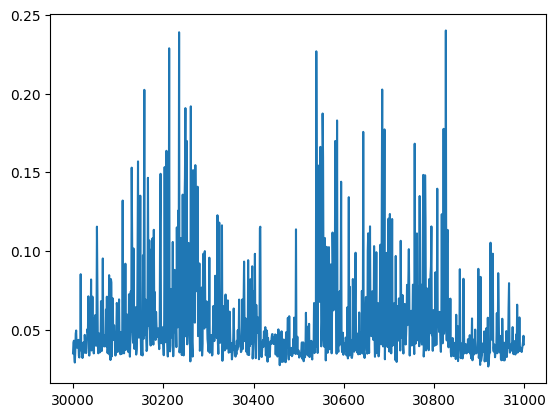

In [4]:
plt.plot(df.iloc[30000:31000].pipelines_status_realtime_pipeline_latency)

<Axes: >

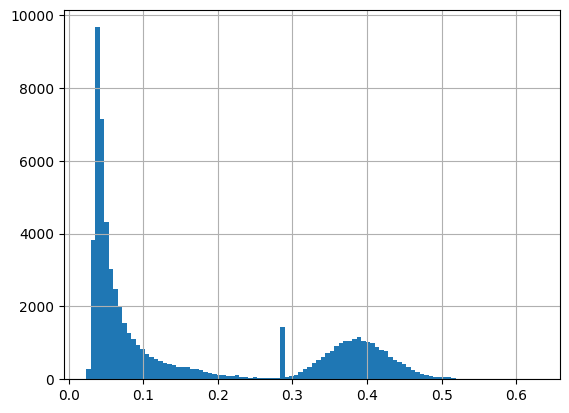

In [5]:
df.pipelines_status_realtime_pipeline_latency.hist(bins=100)

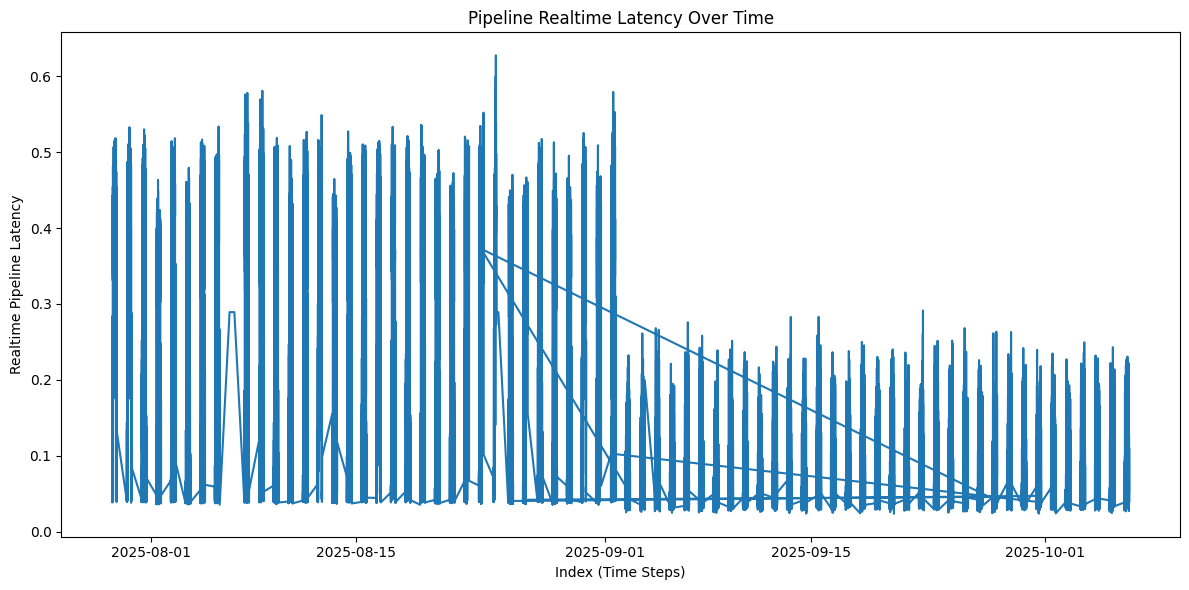

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(df['date'],df['pipelines_status_realtime_pipeline_latency'])
plt.title('Pipeline Realtime Latency Over Time')
plt.xlabel('Index (Time Steps)')
plt.ylabel('Realtime Pipeline Latency')
plt.tight_layout()
plt.show()

In [7]:
# Vectorized approach (faster)
def create_transition_feature_vectorized(df, column='pipelines_status_realtime_pipeline_latency', 
                                       threshold=0.2, window=10):
    """
    Create binary feature that is 1 if there's a transition from under threshold 
    to above threshold in the next window rows.
    Vectorized version for better performance
    """
    series = df[column]
    result = []
    
    for i in range(len(series)):
        # Get next window
        end_idx = min(i + window + 1, len(series))
        window_data = series.iloc[i:end_idx]
        
        # Check for transition: create boolean masks
        under_threshold = window_data < threshold
        above_threshold = window_data >= threshold
        
        # Check if we have a transition from under to over
        has_transition = False
        for j in range(len(window_data) - 1):
            if under_threshold.iloc[j] and above_threshold.iloc[j + 1]:
                has_transition = True
                break
                
        result.append(1 if has_transition else 0)
    
    return result

# Apply the vectorized version
df['latency_spike_next_10'] = create_transition_feature_vectorized(df)

In [8]:
df.latency_spike_next_10.value_counts()

0    59350
1     6831
Name: latency_spike_next_10, dtype: int64

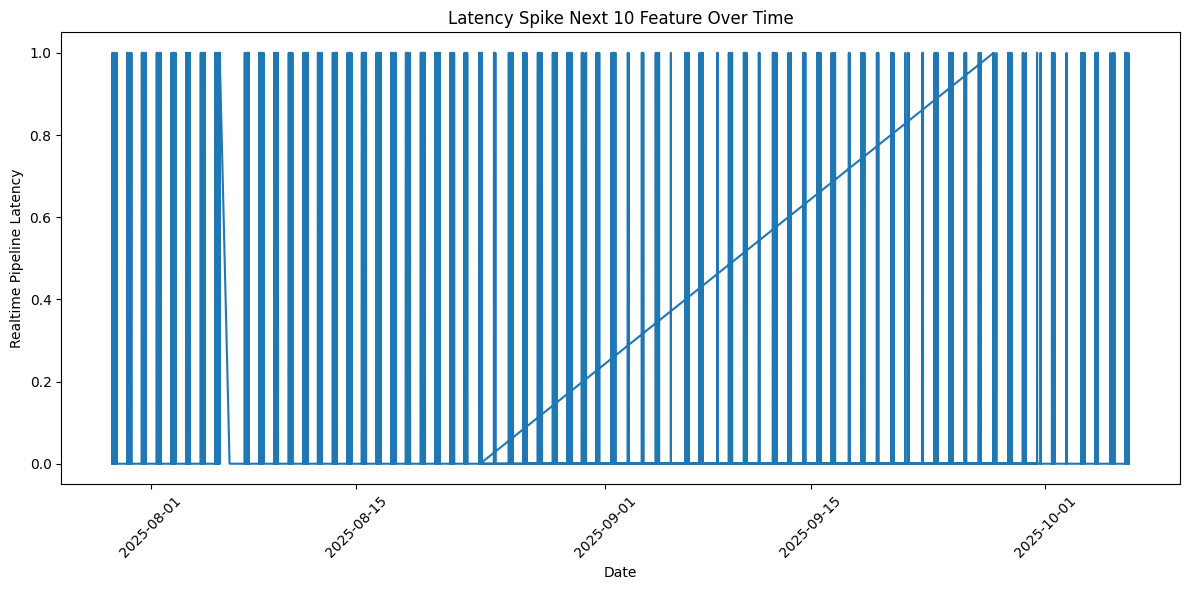

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['latency_spike_next_10'])
plt.title('Latency Spike Next 10 Feature Over Time')
plt.xlabel('Date')
plt.ylabel('Realtime Pipeline Latency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
def create_constant_values_feature(df, window_size=40, transition_col='latency_spike_next_10'):
    """
    Create binary feature that marks windows of constant values (no transitions) for deletion.
    Uses rolling windows and updates values when transitions are detected in subsequent windows.
    """
    n = len(df)
    constant_values_to_be_deleted = [1] * n  # Initialize all to 0
    
    # Step 1: Mark windows with no transitions as 1
    for i in range(n - window_size + 1):
        window_end = i + window_size
        window_transitions = df[transition_col].iloc[i:window_end]

        # If current window has transitions, set all rows in this window to 0
        if window_transitions.sum() > 0:
            for j in range(i, window_end):
                constant_values_to_be_deleted[j] = 0
    
    
    return constant_values_to_be_deleted

# Apply the function
df['constant_values_to_be_deleted'] = create_constant_values_feature(df)

# Check the results
print(f"Total rows: {len(df)}")
print(f"Rows marked for deletion: {df['constant_values_to_be_deleted'].sum()}")
print(f"Rows to keep: {len(df) - df['constant_values_to_be_deleted'].sum()}")
print(f"Percentage marked for deletion: {df['constant_values_to_be_deleted'].mean()*100:.2f}%")

Total rows: 66181
Rows marked for deletion: 34936
Rows to keep: 31245
Percentage marked for deletion: 52.79%


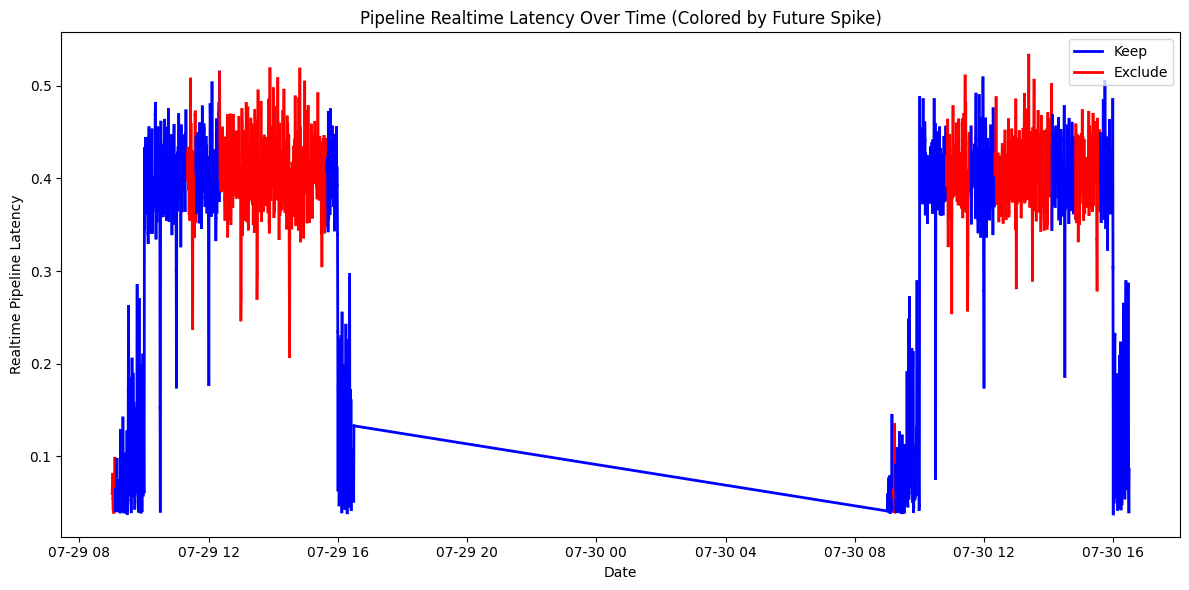

In [11]:
filt = df[df["date"] < "2025-07-31"]
plt.figure(figsize=(12, 6))

# Plot the line segments with colors
for i in range(len(filt) - 1):
    plt.plot(filt['date'].iloc[i:i+2],
             filt['pipelines_status_realtime_pipeline_latency'].iloc[i:i+2],
             color='red' if filt['constant_values_to_be_deleted'].iloc[i] == 1 else 'blue',
             linewidth=2)

plt.title('Pipeline Realtime Latency Over Time (Colored by Future Spike)')
plt.xlabel('Date')
plt.ylabel('Realtime Pipeline Latency')

# Create proper legend with custom handles
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='blue', lw=2, label='Keep'),
                   Line2D([0], [0], color='red', lw=2, label='Exclude')]
plt.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

In [12]:
def create_transition_feature_by_cluster(df, column='pipelines_status_realtime_pipeline_latency', 
                                        window=10, cluster_col='cluster'):
   """Create transition feature with cluster-specific thresholds"""
   thresholds = {
       'eb0e3eaa-b668-4ad6-bc10-2bb0eb7da259': 0.2,
       'fd7816db-7948-4602-af7a-1d51900792a7': 0.045
   }
   result = []
   
   for i in range(len(df)):
       cluster = df[cluster_col].iloc[i]
       threshold = thresholds.get(cluster, 0.2)
       
       end_idx = min(i + window + 1, len(df))
       window_data = df.iloc[i:end_idx]
       
       # Check for transition only within same cluster
       has_transition = False
       for j in range(len(window_data) - 1):
           if (window_data[cluster_col].iloc[j] == cluster and 
               window_data[cluster_col].iloc[j + 1] == cluster):
               if (window_data[column].iloc[j] < threshold and 
                   window_data[column].iloc[j + 1] >= threshold):
                   has_transition = True
                   break
       
       result.append(1 if has_transition else 0)
   
   return result

def create_constant_values_feature_by_cluster(df, window_size=40, transition_col='latency_spike_next_10',
                                             cluster_col='cluster'):
   """Mark windows for deletion, processing each cluster separately"""
   n = len(df)
   constant_values_to_be_deleted = [1] * n
   
   for cluster in df[cluster_col].unique():
       cluster_indices = df[df[cluster_col] == cluster].index.tolist()
       
       for i in range(len(cluster_indices) - window_size + 1):
           window_indices = cluster_indices[i:i + window_size]
           window_transitions = df.loc[window_indices, transition_col]
           
           if window_transitions.sum() > 0:
               for idx in window_indices:
                   constant_values_to_be_deleted[idx] = 0
   
   return constant_values_to_be_deleted

# Apply
df['latency_spike_next_10'] = create_transition_feature_by_cluster(df)
df['constant_values_to_be_deleted'] = create_constant_values_feature_by_cluster(df,window_size=10)
# Check the results
print(f"Total rows: {len(df)}")
print(f"Rows marked for deletion: {df['constant_values_to_be_deleted'].sum()}")
print(f"Rows to keep: {len(df) - df['constant_values_to_be_deleted'].sum()}")
print(f"Percentage marked for deletion: {df['constant_values_to_be_deleted'].mean()*100:.2f}%")

Total rows: 66181
Rows marked for deletion: 23444
Rows to keep: 42737
Percentage marked for deletion: 35.42%


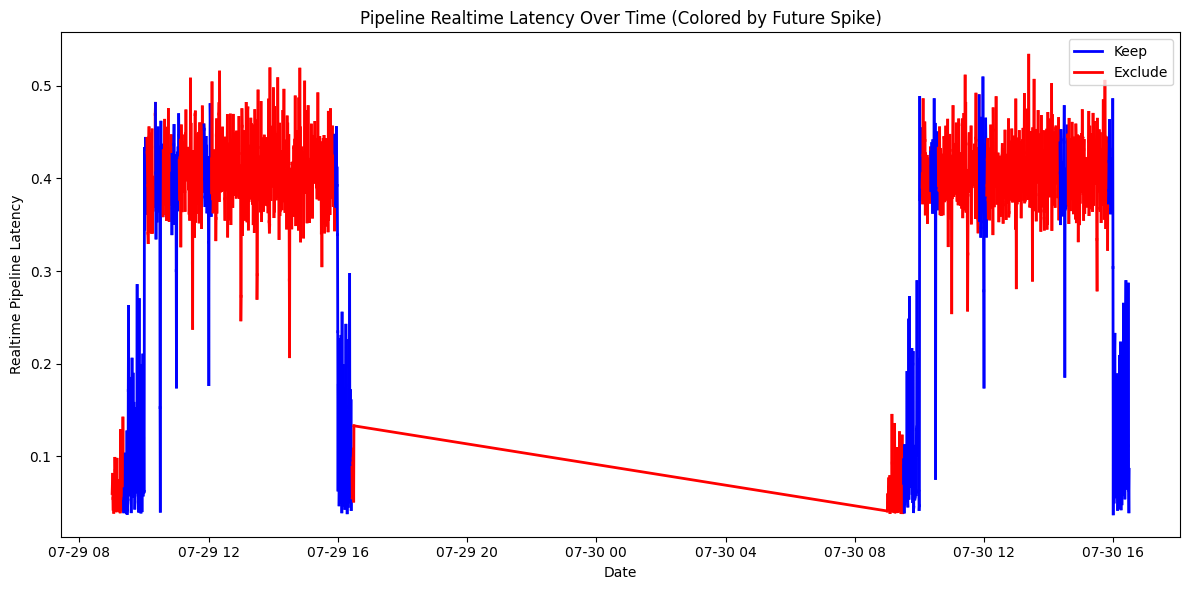

In [13]:
filt = df[(df["date"] < "2025-07-31") & (df["cluster"] == "eb0e3eaa-b668-4ad6-bc10-2bb0eb7da259")]
plt.figure(figsize=(12, 6))

# Plot the line segments with colors
for i in range(len(filt) - 1):
    plt.plot(filt['date'].iloc[i:i+2],
             filt['pipelines_status_realtime_pipeline_latency'].iloc[i:i+2],
             color='red' if filt['constant_values_to_be_deleted'].iloc[i] == 1 else 'blue',
             linewidth=2)

plt.title('Pipeline Realtime Latency Over Time (Colored by Future Spike)')
plt.xlabel('Date')
plt.ylabel('Realtime Pipeline Latency')

# Create proper legend with custom handles
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='blue', lw=2, label='Keep'),
                   Line2D([0], [0], color='red', lw=2, label='Exclude')]
plt.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

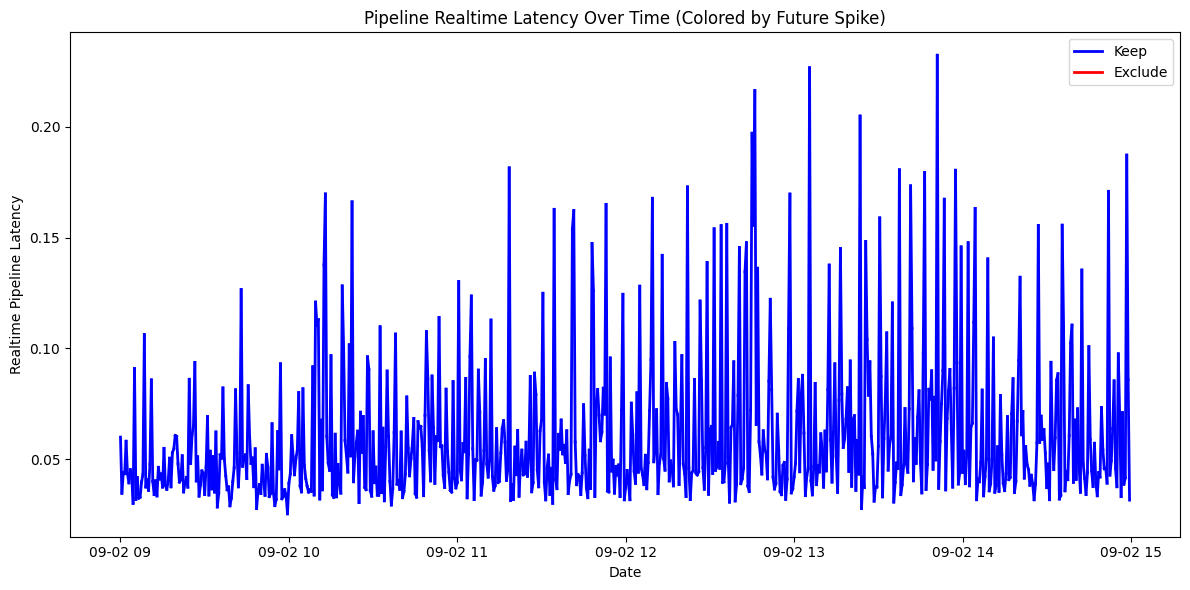

In [14]:
filt = df[(df["date"] < "2025-09-02 15") & (df["cluster"] == "fd7816db-7948-4602-af7a-1d51900792a7")]
plt.figure(figsize=(12, 6))

# Plot the line segments with colors
for i in range(len(filt) - 1):
    plt.plot(filt['date'].iloc[i:i+2],
             filt['pipelines_status_realtime_pipeline_latency'].iloc[i:i+2],
             color='red' if filt['constant_values_to_be_deleted'].iloc[i] == 1 else 'blue',
             linewidth=2)

plt.title('Pipeline Realtime Latency Over Time (Colored by Future Spike)')
plt.xlabel('Date')
plt.ylabel('Realtime Pipeline Latency')

# Create proper legend with custom handles
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='blue', lw=2, label='Keep'),
                   Line2D([0], [0], color='red', lw=2, label='Exclude')]
plt.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

In [15]:
df_filtered = df[df['constant_values_to_be_deleted'] == 0]
df_filtered.cluster.value_counts()

fd7816db-7948-4602-af7a-1d51900792a7    33039
eb0e3eaa-b668-4ad6-bc10-2bb0eb7da259     9698
Name: cluster, dtype: int64

In [16]:
# Apply the original functions
df['latency_spike_next_10'] = create_transition_feature_by_cluster(df)
df['constant_values_to_be_deleted'] = create_constant_values_feature_by_cluster(df)

# Filter
df_filtered = df[df['constant_values_to_be_deleted'] == 0]

# Separate clusters
fd_cluster = df_filtered[df_filtered['cluster'] == 'fd7816db-7948-4602-af7a-1d51900792a7']
eb_cluster = df_filtered[df_filtered['cluster'] == 'eb0e3eaa-b668-4ad6-bc10-2bb0eb7da259']

# Keep only the most recent rows from fd_cluster to match eb_cluster size
rows_to_drop = len(fd_cluster) - len(eb_cluster)
fd_cluster_trimmed = fd_cluster.iloc[rows_to_drop:]  # Drop oldest, keep newest

# Combine
df_balanced = pd.concat([fd_cluster_trimmed, eb_cluster]).sort_index()
df_balanced.reset_index(drop=True, inplace=True)

In [17]:
def reorder_clusters_for_splits(df, cluster_col='cluster', train_ratio=0.7, val_ratio=0.1, test_ratio=0.2):
   """
   Reorder dataframe by clusters for train/val/test splits.
   Order: train_A, train_B, val_A, val_B, test_A, test_B
   """
   # Get unique clusters
   clusters = df[cluster_col].unique()
   if len(clusters) != 2:
       raise ValueError(f"Expected 2 clusters, got {len(clusters)}")
   
   # Separate clusters
   cluster_a = df[df[cluster_col] == clusters[0]]
   cluster_b = df[df[cluster_col] == clusters[1]]
   
   # Calculate split sizes for each cluster
   n_a = len(cluster_a)
   n_b = len(cluster_b)
   
   a_train_size = int(n_a * train_ratio)
   a_val_size = int(n_a * val_ratio)
   a_test_size = n_a - a_train_size - a_val_size
   
   b_train_size = int(n_b * train_ratio)
   b_val_size = int(n_b * val_ratio)
   b_test_size = n_b - b_train_size - b_val_size
   
   # Split each cluster
   a_train = cluster_a.iloc[:a_train_size]
   a_val = cluster_a.iloc[a_train_size:a_train_size + a_val_size]
   a_test = cluster_a.iloc[a_train_size + a_val_size:]
   
   b_train = cluster_b.iloc[:b_train_size]
   b_val = cluster_b.iloc[b_train_size:b_train_size + b_val_size]
   b_test = cluster_b.iloc[b_train_size + b_val_size:]
   
   # Combine in specified order
   df_reordered = pd.concat([
       a_train, b_train,
       a_val, b_val,
       a_test, b_test
   ])
   
   df_reordered.reset_index(drop=True, inplace=True)
   return df_reordered

# Apply
df_reordered = reorder_clusters_for_splits(df_balanced)

In [18]:
df_reordered.cluster.value_counts()

eb0e3eaa-b668-4ad6-bc10-2bb0eb7da259    19733
fd7816db-7948-4602-af7a-1d51900792a7    19733
Name: cluster, dtype: int64

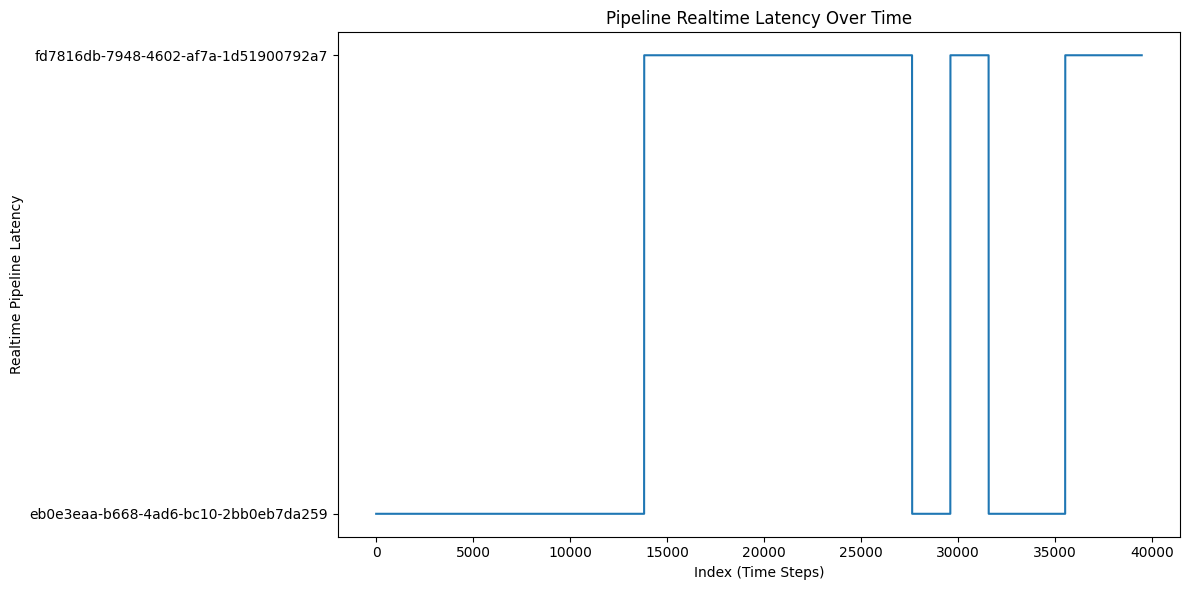

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(df_reordered.index,df_reordered['cluster'])
plt.title('Pipeline Realtime Latency Over Time')
plt.xlabel('Index (Time Steps)')
plt.ylabel('Realtime Pipeline Latency')
plt.tight_layout()
plt.show()

In [20]:
df_reordered.drop(columns=['latency_spike_next_10','constant_values_to_be_deleted'], inplace=True)
df_reordered.to_csv('/home/jolivera/Documents/CloudSkin/Time-Series-Library/dataset/training_dataset/new_queues_concurrency_4_after_migration/preprocessed_data_filtered.csv', index=False)